In [10]:
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, Lasso
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
from sklearn.inspection import DecisionBoundaryDisplay
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error as mae

## Regression without over sampling the base dataset

In [203]:
df = pd.read_csv("./data/normalized_data")

In [205]:
df = df.drop(columns=[ 'Unnamed: 0'])

In [207]:
df = df[df['CLAIM_FLAG'] == 1]

In [183]:
scaleclms = ['YOJ','INCOME','HOME_VAL','BLUEBOOK','TRAVTIME','TIF','OLDCLAIM','CLM_FREQ','MVR_PTS', 'CAR_AGE', 'GEN_AGE']

In [185]:
scaler = MinMaxScaler()

In [187]:
df[scaleclms] = scaler.fit_transform(df[scaleclms])

In [209]:
y = df['CLM_AMT']
x = df.drop(columns=['CLM_AMT'])

In [211]:
y_log = np.log(y)

In [213]:
x_train, x_test, y_train, y_test = train_test_split(x, y_log, test_size=0.2, random_state=42)

In [215]:
regressors = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(random_state=0)),
    ('Neural Network Regression ', MLPRegressor(random_state=0, alpha=1, max_iter=1000)),
    ('Lasso Regression ', Lasso(random_state=0)),
    ('Decision Tree Regression ', DecisionTreeRegressor(random_state=0, max_depth=5)),
    ('Random Forest', RandomForestRegressor(random_state=0, max_depth=5, n_estimators=10, max_features=1)),
    ('KNN Model ', KNeighborsRegressor(3)),
    ('Support Vector Machines (SVM)', SVR(gamma=2, C=1)),
    
]

In [217]:
claim_amounts = df[df['CLAIM_FLAG'] == 0]['CLM_AMT']

# Display the result
print(min(claim_amounts))

ValueError: min() iterable argument is empty

In [219]:
performance = []
for name, rgr in regressors:
    rgr.fit(x_train, y_train)
    y_pred = rgr.predict(x_test)
    y_pred_original = np.exp(y_pred)
    y_test_original = np.exp(y_test)

    perf_tuple = (name, mae(y_test_original , y_pred_original))
    print(perf_tuple)
    performance.append(perf_tuple)

('Linear Regression', 2973.7171873920906)
('Ridge Regression', 2973.4451072276097)
('Neural Network Regression ', 2.9245928687922187e+109)
('Lasso Regression ', 2935.5231297818605)
('Decision Tree Regression ', 3144.476336721594)
('Random Forest', 2954.1954497649044)
('KNN Model ', 3526.2979291030883)
('Support Vector Machines (SVM)', 2957.35356264854)


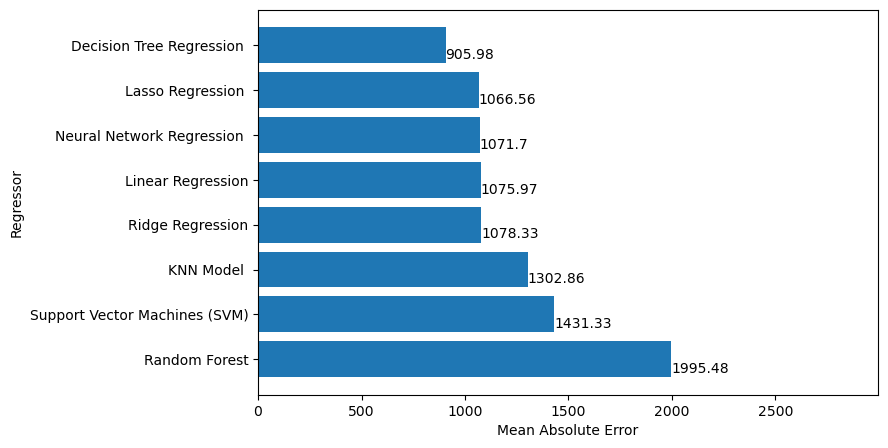

In [174]:
x, y = list(zip(*sorted(performance, key=lambda x: x[1], reverse=True)))
plt.figure(figsize=(8,5))
plt.barh(x,y)
plt.xlim(right=max(y)+1000)
plt.xlabel('Mean Absolute Error')
plt.ylabel('Regressor')
for i in range(len(y)):
    plt.text(y[i]+0.01,i-0.3,round(y[i],2))
plt.show()

## Regression with oversampling the base dataset

In [89]:
df_resampled = pd.read_csv("./data/normalized_data")

In [91]:
df_resampled = df_resampled.drop(columns=[ 'Unnamed: 0'])

In [93]:
y_re = df_resampled['CLAIM_FLAG']
x_re = df_resampled.drop(columns=['CLAIM_FLAG'])

In [95]:
x_re_train, x_re_test, y_re_train, y_re_test = train_test_split(x_re, y_re, test_size=0.2, random_state=42)

In [97]:
from imblearn.over_sampling import SMOTE

# Use SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x_re_train, y_re_train)

In [99]:
X_resampled_df = pd.DataFrame(X_resampled, columns=x_re_train.columns)

# Add the resampled target variable to the DataFrame
y_resampled_df = pd.DataFrame(y_resampled, columns=['CLAIM_FLAG'])  # Rename 'target' as needed

# Combine X_resampled_df and y_resampled_df into one DataFrame
df_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1)

In [101]:
df_resampled.shape

(12100, 44)

In [103]:
df_resampled = df_resampled[df_resampled['CLAIM_FLAG'] == 1]

In [105]:
df_resampled.shape

(6050, 44)

In [107]:
pd.set_option('display.max_columns', None)

In [109]:
df_resampled.head()

,KIDSDRIV,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,TRAVTIME,BLUEBOOK,TIF,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,GEN_AGE,GENDER_M,GENDER_z_F,EDUCATION_<High School,EDUCATION_Bachelors,EDUCATION_Masters,EDUCATION_PhD,EDUCATION_z_High School,OCCUPATION_Clerical,OCCUPATION_Doctor,OCCUPATION_Home Maker,OCCUPATION_Lawyer,OCCUPATION_Manager,OCCUPATION_Professional,OCCUPATION_Student,OCCUPATION_z_Blue Collar,CAR_USE_Commercial,CAR_USE_Private,CAR_TYPE_Minivan,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV,URBANICITY_Highly Urban/ Urban,URBANICITY_z_Highly Rural/ Rural,CLAIM_FLAG
3,0.0,1.0,6.0,56014.0,0.0,234014.0,1.0,28.0,7100.0,4.0,0.0,0.0,0.0,0.0,0.0,6098.0,8.0,39.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
11,1.0,1.0,7.0,102339.0,1.0,0.0,0.0,9.0,27420.0,10.0,0.0,0.0,0.0,0.0,8.0,5342.0,11.0,60.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
12,2.0,3.0,12.0,40012.0,0.0,200016.0,1.0,20.0,9200.0,7.0,0.0,3119.0,2.0,0.0,2.0,3246.0,1.0,37.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
21,0.0,0.0,10.0,64777.0,0.0,237421.0,0.0,47.0,31120.0,4.0,0.0,23078.0,2.0,1.0,3.0,3456.0,8.0,47.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
31,0.0,2.0,9.0,33538.0,1.0,0.0,0.0,29.0,8250.0,4.0,1.0,38845.0,2.0,1.0,2.0,5810.0,1.0,34.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [111]:
scaleclms = ['YOJ','INCOME','HOME_VAL','BLUEBOOK','TRAVTIME','TIF','OLDCLAIM','CLM_FREQ','MVR_PTS', 'CAR_AGE', 'GEN_AGE']

In [113]:
scaler = StandardScaler()

In [115]:
df_resampled[scaleclms] = scaler.fit_transform(df_resampled[scaleclms])

In [117]:
df_resampled.head()

,KIDSDRIV,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,TRAVTIME,BLUEBOOK,TIF,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,GEN_AGE,GENDER_M,GENDER_z_F,EDUCATION_<High School,EDUCATION_Bachelors,EDUCATION_Masters,EDUCATION_PhD,EDUCATION_z_High School,OCCUPATION_Clerical,OCCUPATION_Doctor,OCCUPATION_Home Maker,OCCUPATION_Lawyer,OCCUPATION_Manager,OCCUPATION_Professional,OCCUPATION_Student,OCCUPATION_z_Blue Collar,CAR_USE_Commercial,CAR_USE_Private,CAR_TYPE_Minivan,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV,URBANICITY_Highly Urban/ Urban,URBANICITY_z_Highly Rural/ Rural,CLAIM_FLAG
3,0.0,1.0,-0.981781,0.114891,0.0,1.019339,1.0,-0.489061,-0.912805,-0.210842,0.0,-0.603991,-1.077400,0.0,-1.077960,6098.0,0.143068,-0.508820,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
11,1.0,1.0,-0.742009,1.231219,1.0,-1.020618,0.0,-1.892024,1.677186,1.511467,0.0,-0.603991,-1.077400,0.0,2.365170,5342.0,0.768261,1.899482,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
12,2.0,3.0,0.456853,-0.270722,0.0,0.722970,1.0,-1.079782,-0.645138,0.650313,0.0,-0.290619,0.697525,0.0,-0.217177,3246.0,-1.315716,-0.738182,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
21,0.0,0.0,-0.022691,0.326059,0.0,1.049039,0.0,0.913902,2.148789,-0.210842,0.0,1.714701,0.697525,1.0,0.213214,3456.0,0.143068,0.408628,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
31,0.0,2.0,-0.262464,-0.426731,1.0,-1.020618,0.0,-0.415221,-0.766225,-0.210842,1.0,3.298842,0.697525,1.0,-0.217177,5810.0,-1.315716,-1.082225,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [119]:
y_reg = df_resampled['CLM_AMT']
x_reg = df_resampled.drop(columns=['CLM_AMT'])

In [121]:
x_reg_train, x_reg_test, y_reg_train, y_reg_test = train_test_split(x_reg, y_reg, test_size=0.2, random_state=42)

In [123]:
regressors = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(random_state=0)),
    ('Neural Network Regression ', MLPRegressor(random_state=0, alpha=1, max_iter=1000)),
    ('Lasso Regression ', Lasso(random_state=0)),
    ('Decision Tree Regression ', DecisionTreeRegressor(random_state=0, max_depth=5)),
    ('Random Forest', RandomForestRegressor(random_state=0, max_depth=5, n_estimators=10, max_features=1)),
    ('KNN Model ', KNeighborsRegressor(3)),
    ('Support Vector Machines (SVM)', SVR(gamma=2, C=1)),
    
]

In [125]:
performance = []
for name, rgr in regressors:
    rgr.fit(x_reg_train, y_reg_train)
    y_reg_pred = rgr.predict(x_reg_test)
    perf_tuple = (name, mae(y_reg_test, y_reg_pred))
    print(perf_tuple)
    performance.append(perf_tuple)

('Linear Regression', 3587.8304580646522)
('Ridge Regression', 3587.40494374118)


/Users/ramlanalmi/Desktop/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


('Neural Network Regression ', 3576.089060995928)
('Lasso Regression ', 3584.80770424203)
('Decision Tree Regression ', 3321.614995204895)
('Random Forest', 3431.20616484271)
('KNN Model ', 2129.3730121834333)
('Support Vector Machines (SVM)', 3022.875401203915)


In [274]:
df_resampled.shape

(6050, 44)

In [211]:
df = df[df['CLAIM_FLAG'] == 1]

In [9]:
df.shape

(2746, 45)

In [276]:
df_resampled.head()

,KIDSDRIV,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,TRAVTIME,BLUEBOOK,TIF,...,CAR_USE_Private,CAR_TYPE_Minivan,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV,URBANICITY_Highly Urban/ Urban,URBANICITY_z_Highly Rural/ Rural,CLAIM_FLAG
3,0.0,1.0,6.0,56014.0,0.0,234014.0,1.0,28.0,7100.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
11,1.0,1.0,7.0,102339.0,1.0,0.0,0.0,9.0,27420.0,10.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
12,2.0,3.0,12.0,40012.0,0.0,200016.0,1.0,20.0,9200.0,7.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
21,0.0,0.0,10.0,64777.0,0.0,237421.0,0.0,47.0,31120.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
31,0.0,2.0,9.0,33538.0,1.0,0.0,0.0,29.0,8250.0,4.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [302]:
scaleclms = ['YOJ','INCOME','HOME_VAL','BLUEBOOK','TRAVTIME','TIF','OLDCLAIM','CLM_FREQ','MVR_PTS', 'CAR_AGE', 'GEN_AGE']

In [304]:
scaler = StandardScaler()

In [306]:
df[scaleclms] = scaler.fit_transform(df[scaleclms])

In [308]:
df_resampled[scaleclms] = scaler.fit_transform(df_resampled[scaleclms])

In [284]:
df_resampled['CLM_AMT']

3        6098.000000
11       5342.000000
12       3246.000000
21       3456.000000
31       5810.000000
            ...     
12095    5757.492996
12096    6459.955765
12097    1705.264152
12098    6411.621179
12099    4369.967288
Name: CLM_AMT, Length: 6050, dtype: float64

In [191]:
df = df_resampled.drop(columns=['CLAIM_FLAG', 'Unnamed: 0'])

KeyError: "['CLAIM_FLAG', 'Unnamed: 0'] not found in axis"

In [219]:
y = df['CLM_AMT']
x = df.drop(columns=['CLM_AMT'])

In [310]:
y = df_resampled['CLM_AMT']
x = df_resampled.drop(columns=['CLM_AMT'])

In [312]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [223]:
regressors = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(random_state=0)),
    ('Neural Network Regression ', MLPRegressor(random_state=0, alpha=1, max_iter=1000)),
    ('Lasso Regression ', Lasso(random_state=0)),
    ('Decision Tree Regression ', DecisionTreeRegressor(random_state=0, max_depth=5)),
    ('Random Forest', RandomForestRegressor(random_state=0, max_depth=5, n_estimators=10, max_features=1)),
    ('KNN Model ', KNeighborsRegressor(3)),
    ('Support Vector Machines (SVM)', SVR(gamma=2, C=1)),
    
]

In [256]:
performance = []
for name, rgr in regressors:
    rgr.fit(x_train, y_train)
    y_pred = rgr.predict(x_test)
    perf_tuple = (name, mae(y_test, y_pred))
    print(perf_tuple)
    performance.append(perf_tuple)

('Linear Regression', 0.2647091405173378)
('Ridge Regression', 0.264707704619041)
('Neural Network Regression ', 39.45122273169486)
('Lasso Regression ', 0.29062913247064137)
('Decision Tree Regression ', 0.0)
('Random Forest', 0.32198784123363694)
('KNN Model ', 0.1913310690603267)
('Support Vector Machines (SVM)', 0.4135714193614427)


In [314]:
performance = []
for name, rgr in regressors:
    rgr.fit(x_train, y_train)
    y_pred = rgr.predict(x_test)
    perf_tuple = (name, mae(y_test, y_pred))
    print(perf_tuple)
    performance.append(perf_tuple)

('Linear Regression', 3587.8304580646522)
('Ridge Regression', 3587.40494374118)


/Users/ramlanalmi/Desktop/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


('Neural Network Regression ', 3576.089060995928)
('Lasso Regression ', 3584.80770424203)
('Decision Tree Regression ', 3321.614995204895)
('Random Forest', 3431.20616484271)
('KNN Model ', 2129.3730121834333)
('Support Vector Machines (SVM)', 3022.875401203915)


In [165]:
performance = []
for name, rgr in regressors:
    rgr.fit(x_train, y_train)
    y_pred = rgr.predict(x_test)
    perf_tuple = (name, mae(y_test, y_pred))
    print(perf_tuple)
    performance.append(perf_tuple)

('Linear Regression', 1080.3618143921665)
('Ridge Regression', 1079.864912892517)
('Neural Network Regression ', 1288.831270558538)
('Lasso Regression ', 1074.3617369798565)
('Decision Tree Regression ', 905.9716957991089)
('Random Forest', 1896.7518022754857)
('KNN Model ', 2204.3941452369404)
('Support Vector Machines (SVM)', 1431.8022821258012)
